# Train: 機械学習モデルを学習する

## なにをするのか

Train フェーズでは、以下の 2 つを行います。

1. 使用する機械学習のアルゴリズムを選定する
2. Preprocess で用意したデータでトレーニングを行う

### アルゴリズムの選択

アルゴリズムは、例えば以下のようなものがあります。

* 教師あり学習
  * 線形回帰
  * 正則化
  * ロジスティック回帰
  * ナイーブベイズ
  * ランダムフォレスト
  * kNN
* 教師なし学習
  * PCA
  * LSA
  * NMF
  * LDA
  * k-means 法
  * 混合ガウス分布
  * LLE
  * t-SNE

※ "見て試してわかる機械学習アルゴリズムの仕組み 機械学習図鑑"の目次より引用

上記のアルゴリズムは一例にすぎず、数多のアルゴリズムが存在します。  
アルゴリズムを選定するにあたって、参考になるチートシート(後述)もありますが、まずは以下を抑えておきましょう。  

#### アルゴリズム選定で抑えておくポイント

##### 1. 解く問題の大別  
機械学習を用いて何がしたいのかをまずは抑えましょう。細かくわけるといくつもありますが、まずは以下の大別を抑えておきましょう。  
大別するだけで使用できるアルゴリズムが絞れます。
  * 教師あり学習  
    * 回帰  
      部品の残存寿命、需要予測など、予測して数値の大小を知りたい場合
    * 分類  
      商品のレコメンド、融資可否の審査、商品の不具合検出など、入力されたデータが何に属するのかを知りたい場合
  * 教師なし学習
    * クラスタリング  
      顧客を属性情報に基づいてグルーピングしたい場合など、機械的にデータをグルーピングしたい場合
    * 次元圧縮
      データの次元(テーブルデータの場合は列)が多すぎて扱いきれない場合に削減する
    * その他
      データの分布からおかしいものを探すなどの異常検出、など
    
##### 2. 要求する速度パフォーマンス
業務を考慮してレイテンシーやスループットに関するシステム要求を抑えておきましょう。  
機械学習モデルを本番運用する際、推論にかけられる時間(レイテンシー)、推論イベントが発生する頻度、再学習にかけられる時間などの制約があります。  
一般に大きいモデルほど精度は良いですが、推論や再学習にかかる時間が大きくなるので、時間制約が厳しいほど使用できるモデルが絞られます。  

##### 3. 推論環境
推論したいデータは、エッジで発生したときに特に考慮すべきポイントです。  
推論場所がクラウドであれば、データをクラウドへ転送する時間的コストが発生しますが、一方で推論環境はリッチかつスケールアウトさせやすいです。  
一方で、推論場所がエッジであればデータの転送コストは少ないですが、推論環境のコンピューティングリソースに制約ができてしまいます。  
ワークロードによって、どこで推論させるのがいいかを考えましょう。特にエッジでの推論はモデル選択の制約となりやすいです。  

##### 4. 複雑さに対する許容範囲
モデルが大きく複雑になれと、精度は上がりやすいですが、反面モデルの理解が難しくなっていきます。  
推論結果に説明が必要な場合（なぜその推論結果になったのかを顧客に説明する必要があるケースなど）は、理解しやすい単純なモデルを選択しましょう。  

##### 5. 精度に関わる要件
どれくらいの精度を出さなければビジネスとして成り立たないかを抑えておきましょう。  
詳しくは、[Business Understanding](./01_business_understandig.ipynb) を参照してください。

### トレーニングの実行
トレーニングを行うためのステップは以下のようなものがあります。  

#### データのロード
使用するモデルを選択できたら早速トレーニングしたいところですが、  
トレーニングするにあたって、データをロードする必要があります。  
[Preprocess](./04_preprocess.ipynb) で用意したデータを読み込みましょう。  
読み込むにあたって、使用するモデルに合わせた形式で読み込みましょう。  

*csv ファイルを pandas DataFrame で読むコード例*  
`df = pd.read_csv("hoge.csv")`

#### データセットを分割
後述のハイパーパラメータの調整やトレーニングが進むにつれて精度が上がっているかを確認するために、
トレーニングデータセットの中から評価データセットを分割して切り出しましょう。
データの分割自体は [04_preprocess.ipynb](./04_preprocess.ipynb) でも使用した、
scikit-learn の `train_test_split` メソッドで出来ます。

#### ハイパーパラメータの決定
ハイパーパラメータはトレーニングする際に設定する必要のあるパラメータです。  
以下は[決定木](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier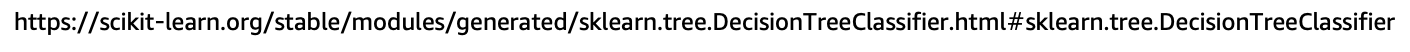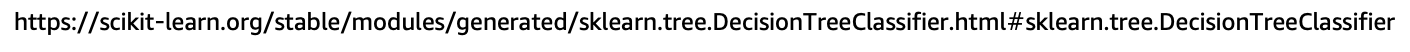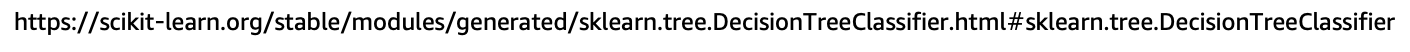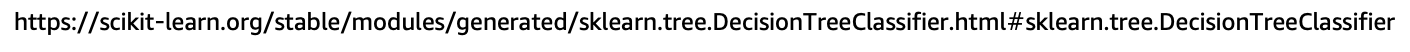)のハイパーパラメータの例(抜粋)です。選択したアルゴリズムに応じてパラメータを設定しましょう。  
* criterion : {“gini”, “entropy”, “log_loss”}, default=”gini”
  分割の品質を測定するための関数
* max_depth : int, default=None  
  木の最大深さ

#### トレーニングの実行
scikit-learn や Keras などのハイレベル API を提供しているフレームワークであれば、  
ハイパーパラメータを指定したモデルインスタンスを設定して、トレーニング API をコールする。

以下は XGBoost の例

```python
# XGBoostRegressor の場合のモデルインスタンス生成
# 引数にハイパーパラメータを入力する
xgb_regressor = xgboost.XGBRegressor(*, objective='reg:squarederror', **kwargs)

# Training
# 最低トレーニングデータセットである X, y を入力すれば動く
# 他の引数はオプションなので必要に応じて入力する
xgb_regressor.fit(X, y, *, sample_weight=None, base_margin=None, eval_set=None, eval_metric=None, early_stopping_rounds=None, verbose=True, xgb_model=None, sample_weight_eval_set=None, base_margin_eval_set=None, feature_weights=None, callbacks=None)
```
#### モデルの中身を覗いて妥当性を確認
出来たモデルを可視化します。可視化できる範囲はアルゴリズムによります。  
どんなカラムが推論結果にどれくらい影響を与えるかなどを確認しましょう。  
**[決定木の例](https://scikit-learn.org/stable/_images/iris.svg)**  
<img src="https://scikit-learn.org/stable/_images/iris.svg" alt="iris.svg" width=700></img>

**[XGBoost の SHAP 値の例](https://shap.readthedocs.io/en/latest/_images/example_notebooks_tabular_examples_tree_based_models_Basic_SHAP_Interaction_Value_Example_in_XGBoost_9_0.png)**  
<img src="https://shap.readthedocs.io/en/latest/_images/example_notebooks_tabular_examples_tree_based_models_Basic_SHAP_Interaction_Value_Example_in_XGBoost_9_0.png" alt="example_notebooks_tabular_examples_tree_based_models_Basic_SHAP_Interaction_Value_Example_in_XGBoost_9_0.png" width=700></img>

#### モデルとトレーニングのメタデータの保存
モデルはメモリに保存されることが多いので、ストレージに保存しましょう。  
また、併せてトレーニングを再現するのに必要な情報保存しましょう。  
例えば以下のような情報が必要です。  
* トレーニングコード(やコードの commit ID)
* 使用したライブラリ(や使用したコンテナや仮想環境)
* 乱数のシード
* 使用したデータ

また、同じトレーニングを２度しなくて済むように、  
トレーニングのメトリクス(Accuracy, Recall, Precision, etc...)も保存しておきましょう。

#### 推論コードの保存
モデルの使い方はトレーニングをした人にしかわかりません。  
Test でモデルの評価を行いますが、Test のために、モデルをロードして推論するコードを残しましょう。

## なぜやるのか

Testで機械学習モデルの有用性を検証するために、学習済みの機械学習モデルが必要です。

## どうやるのか

モデルの選択、モデルの学習、学習のチューニングの3段階で進めます。モデルの選択は、Business Understandingで定めたゴールと、Preprocessで用意したデータに合わせて行います。

プログラミング演習ではモデルの選択と学習、コミュニケーション演習では選択と学習の妥当性を確認するためのコミュニケーションを学びます。

### プログラミング演習

#### モデルの選択

モデルの選択から行います。`scikit-learn`で提示されているフローチャートは、モデルを選択するのに役立ちます。近年はニューラルネットワークでなんでもできてしまう風潮がありますが、シンプルなモデルほど予測の根拠が分析しやすいためシンプルなモデルから始めることをお勧めします。

<img src="./images/05_train_001.PNG" alt="05_train_001.PNG" width=700></img>

今回は「データ量が50以上」、「分類ではない」、「数値を予測する」、「データ量が100,000以下」、「数個の特徴が予測に貢献する」ため、[`ElasticNet`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html)/[`Lasso`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html)に該当します。いずれも線形回帰のモデルです。モデルの詳細についてはハンズオンで詳しく触れませんが、`Lasso`の特性も含む`ElasticNet`を採用します。

学習するため、前処理済みのデータを読み込みます。

In [1]:
from pathlib import Path
import pandas as pd


data_path = Path("../data/processed/train.csv")
df = pd.read_csv(data_path)

きちんと読み込めていることを確認します。

In [2]:
df

,SalePrice,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,LandSlope,LotConfig,LotShape,MasVnrType,PavedDrive,RoofMatl,RoofStyle,SaleType,Street,Utilities
0,-0.656408,-0.864360,-0.181556,-0.270740,-0.756962,1.280027,-0.105076,0.951120,-0.001916,0.073507,...,1.0,5.0,4.0,2.0,3.0,2.0,4.0,9.0,2.0,1.0
1,-0.658088,-0.172398,-0.857978,-0.447101,0.803421,-0.506143,-1.303255,-1.647722,-0.559366,-0.952223,...,1.0,5.0,4.0,3.0,3.0,2.0,2.0,9.0,2.0,1.0
2,-0.622791,-0.864360,0.060023,-0.310631,-0.756962,-0.506143,-0.271490,-1.070201,-0.559366,-0.001713,...,1.0,5.0,4.0,3.0,3.0,2.0,4.0,9.0,2.0,1.0
3,-1.379166,-0.172398,-0.809662,-0.098682,-0.756962,-0.506143,-1.336538,-1.647722,-0.559366,-0.213697,...,1.0,5.0,4.0,3.0,3.0,2.0,2.0,9.0,2.0,1.0
4,-0.547153,0.750217,0.156654,0.041882,-1.537153,-0.506143,-0.071794,-0.781441,-0.559366,-0.952223,...,1.0,5.0,4.0,3.0,3.0,2.0,4.0,9.0,2.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
969,0.570601,-0.864360,0.204970,0.157882,0.803421,-0.506143,0.860123,0.566106,0.668276,0.620563,...,1.0,5.0,4.0,2.0,3.0,2.0,4.0,9.0,2.0,1.0
970,-0.698428,3.056755,-0.326504,-0.028663,-0.756962,1.280027,-1.003710,0.710486,-0.559366,-0.152153,...,1.0,5.0,4.0,3.0,3.0,2.0,2.0,9.0,2.0,1.0
971,0.520176,0.058255,-0.036609,0.000311,0.803421,0.386942,0.094620,-0.540808,0.943869,1.005781,...,1.0,1.0,1.0,4.0,3.0,2.0,2.0,9.0,2.0,1.0
972,-0.030465,1.442178,-1.244504,-0.773580,0.803421,-0.506143,1.159668,1.047373,-0.459150,-0.915752,...,1.0,5.0,4.0,2.0,3.0,2.0,2.0,7.0,2.0,1.0


#### データセットを分割
今回はトレーニングデータセットをトレーニング用と評価用に分割します。  
また、トレーニングを行うためにデータセットから教師ラベルを分離します。

In [3]:
from sklearn.model_selection import train_test_split

train_df, valid_df = train_test_split(df, test_size=0.2, shuffle=True, random_state=40) 
train_X, valid_X = train_df.drop("SalePrice", axis=1), valid_df.drop("SalePrice", axis=1)
train_y, valid_y = train_df["SalePrice"], valid_df["SalePrice"]

#### ハイパーパラメータの決定
今回は ElasticNet の `l1_ratio` のみ明示的に設定することとします。(他はデフォルト値)

In [4]:
hps = {
    'l1_ratio': 0.05,
}

#### モデルの学習

モデルの学習を行います。`scikit-learn`では`fit`するだけです。驚くほどシンプルですが、これで学習は完了です。
また `score` メソッドで精度を確認できます。精度を追求したい場合はハイパーパラメータを調整して再度実行してください。

In [5]:
from sklearn.linear_model import ElasticNet

model = ElasticNet(**hps)
model.fit(train_X, train_y)
model_score = model.score(valid_X, valid_y)
print(f'score : {model_score}')

score : 0.6376219984278403


#### モデルの中身を覗いて妥当性を確認
`ElasticNet`は線形のモデルのため、入力データの各特徴に対する重みを持ちます。重みが大きいほど重要な特徴ということです。重みを可視化してみましょう。

<AxesSubplot:>

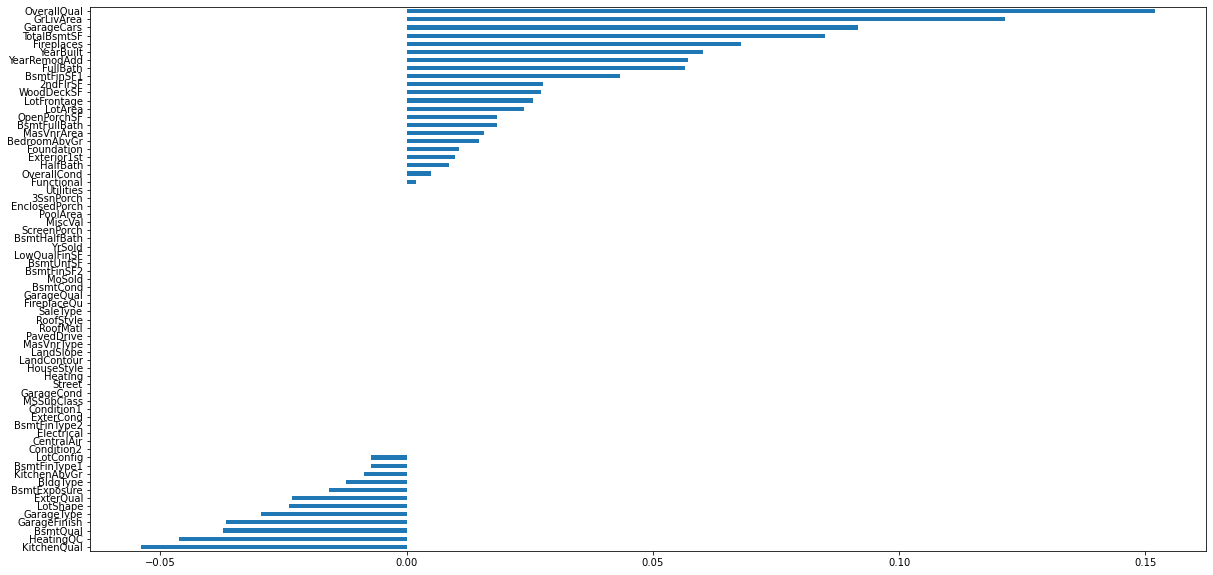

In [6]:
pd.Series(model.coef_, index=model.feature_names_in_).sort_values().plot.barh(figsize=(20, 10))

Analyzeの結果が示唆するように、OverallQualに重みがかかっていることが読み取れます。

*Exercise: 他のモデルでも学習してみましょう。 例: RandomForestRegressor*

※[RandomForestRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html)は、決定木という線形とは異なるタイプのモデルです。複数の分類モデルでデータを細かく分割していき、最終的な分割データの平均値を予測値とします。

In [7]:
from sklearn.ensemble import RandomForestRegressor

other_hps = {
    'n_estimators': 20,
    'max_features': 'auto'
}

other_model = RandomForestRegressor(**other_hps)
other_model.fit(train_X, train_y)
other_model_score = other_model.score(valid_X,valid_y)
print(f'score : {other_model_score}')

score : 0.8242720500225741


<AxesSubplot:>

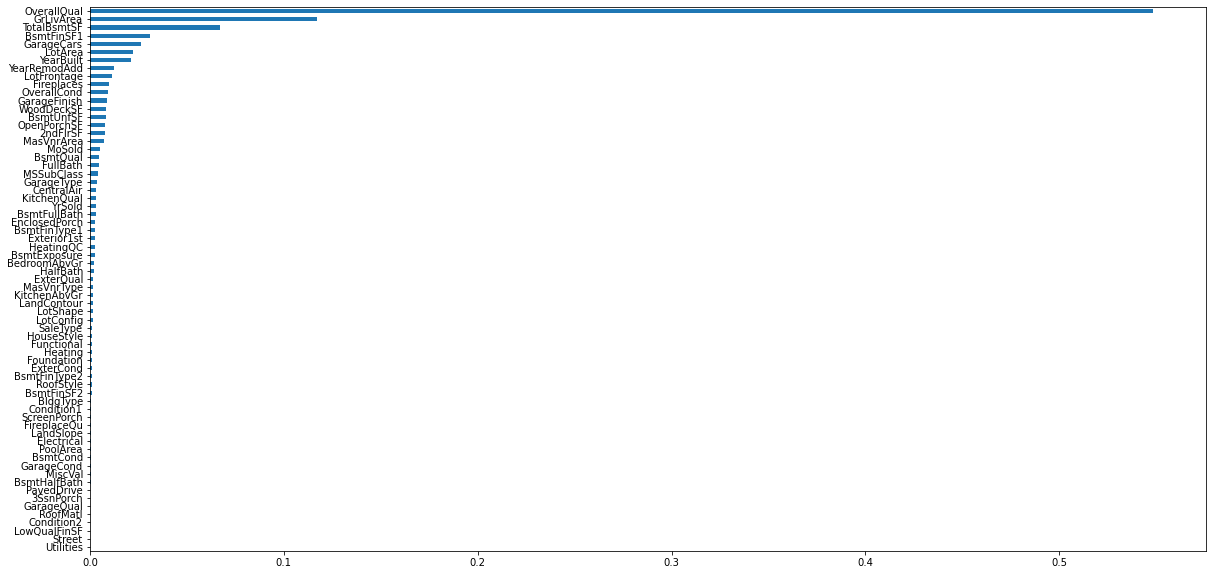

In [8]:
pd.Series(other_model.feature_importances_, index=train_X.columns).sort_values().plot.barh(figsize=(20, 10))

#### モデルとトレーニングのメタデータの保存
モデルの学習ができました。評価はTestで行うので、モデルを保存しておきます。  

In [9]:
from joblib import dump


# 2つとも保存します。
model_dict = {"model": model, "other_model": other_model}
for model_name in model_dict:
    model_path = Path(f"../model/{model_name}.joblib")
    dump(model_dict[model_name], model_path)

今回はメタデータとして、ハイパーパラメータだけ保存しておきます。

In [10]:
from json import dumps

with open(f'../model/hps.json','wt') as f:
    f.write(dumps(hps))
with open(f'../model/other_hps.json','wt') as f:
    f.write(dumps(other_hps))

今回は単にモデルを学習しましたが、学習を行う際は様々なパラメーターがあります。パラメーター次第で予測の精度が変わるため、問題に合わせた適切なパラメーターを探索することを**ハイパーパラメーターチューニング**と呼びます。

* モデルのパラメーター: 深層学習のモデルであれば、レイヤ数など。
* 学習のパラメーター: 勾配法であれば、学習率など。
* データのパラメーター: データの水増し手法を使っている場合、使う手法のバリエーションなど。

最後に出来たモデルで推論し、推論コードを保存し、次に引き継ぎましょう。  
以下のコードを `Restart Kernel` してから実行し動作することを確認します。

In [11]:
# 推論コード実行
from joblib import load
import pandas as pd

df = pd.read_csv('../data/processed/train.csv').drop("SalePrice", axis=1)
model = load('../model/model.joblib')
model.predict(df)

array([-3.93534173e-01, -2.12833354e-01, -6.74114334e-01, -1.00992111e+00,
       -6.41318753e-01, -5.08311922e-01,  4.11489924e-02, -7.60273176e-01,
       -3.94315247e-01,  1.05590914e+00, -2.48448328e-01,  2.17794311e-01,
       -6.13583305e-01,  8.00112003e-02,  1.81157708e-01,  3.60495828e-01,
       -1.01603810e-01,  2.55892059e-01, -7.91646650e-01,  3.37192682e-01,
        2.06727776e-01,  7.08321617e-01, -2.47251332e-01, -8.09860631e-01,
        1.07828740e+00,  7.66113252e-01,  5.07425345e-01,  3.54258121e-01,
       -1.12743428e+00,  2.00070196e-01, -3.08008616e-01, -5.65395918e-01,
        6.55840492e-01,  6.05409288e-01, -1.08220181e+00,  1.23086926e+00,
       -6.14212114e-02, -6.76481935e-01,  3.48970206e-01,  6.48404057e-01,
        8.38355390e-01,  1.23590987e+00, -6.54971344e-01,  5.13581259e-01,
       -5.01688751e-02, -6.77868750e-01, -2.05201050e-01, -6.10500872e-01,
        5.61767263e-01,  3.06761156e-02, -5.40640940e-01, -2.04269506e-01,
       -3.82818169e-01, -

動作確認が取れたらモデルやデータがどこに保存されても動くように環境変数で受け取れるように修正して保存します。

In [12]:
%%writefile ../model/inference.py
from joblib import load
import pandas as pd
import argparse

def main():
    parser = argparse.ArgumentParser()
    parser.add_argument('--csv', type=str, default=None, help='specify csv file')
    parser.add_argument('--model', type=str, default=None, help='specify elasticnet model file')
    args = parser.parse_args()
    df = pd.read_csv(args.csv).drop("SalePrice", axis=1)
    model = load(args.model)
    prediction = model.predict(df)
    print(prediction)
if __name__ == '__main__':
    main()

Overwriting ../model/inference.py


最後に書いたコードの動作確認をします

In [13]:
!python ../model/inference.py --csv ../data/processed/train.csv --model ../model/model.joblib

[-3.93534173e-01 -2.12833354e-01 -6.74114334e-01 -1.00992111e+00
 -6.41318753e-01 -5.08311922e-01  4.11489924e-02 -7.60273176e-01
 -3.94315247e-01  1.05590914e+00 -2.48448328e-01  2.17794311e-01
 -6.13583305e-01  8.00112003e-02  1.81157708e-01  3.60495828e-01
 -1.01603810e-01  2.55892059e-01 -7.91646650e-01  3.37192682e-01
  2.06727776e-01  7.08321617e-01 -2.47251332e-01 -8.09860631e-01
  1.07828740e+00  7.66113252e-01  5.07425345e-01  3.54258121e-01
 -1.12743428e+00  2.00070196e-01 -3.08008616e-01 -5.65395918e-01
  6.55840492e-01  6.05409288e-01 -1.08220181e+00  1.23086926e+00
 -6.14212114e-02 -6.76481935e-01  3.48970206e-01  6.48404057e-01
  8.38355390e-01  1.23590987e+00 -6.54971344e-01  5.13581259e-01
 -5.01688751e-02 -6.77868750e-01 -2.05201050e-01 -6.10500872e-01
  5.61767263e-01  3.06761156e-02 -5.40640940e-01 -2.04269506e-01
 -3.82818169e-01 -9.95130669e-01  4.49493717e-01 -1.16356626e+00
  8.66547439e-01  4.64585087e-01  1.00133157e+00 -1.92062197e-02
  3.95165288e-01 -3.88932

### コミュニケーション演習

プログラミング演習で次の手順で機械学習モデルの学習を行いました。学習の妥当性を確認するために誰に何を依頼すべきでしょうか。

* モデルの選択
* モデルの学習

ロールの種別

| 英語名             | 日本語名                   | 役割                                                                 |
|--------------------|----------------------------|----------------------------------------------------------------------|
| Product Manager    | プロダクトマネージャー     | ユーザー体験を向上させるために実装すべきソフトウェア機能を定義する。 |
| Business Analyst   | ビジネスアナリスト         | 解決すべきビジネス上の問題を定義する                                 |
| Data Analyst       | データアナリスト           | データの可視化と分析で問題を定量的に特定する。                       |
| Architect          | アーキテクト               | ソフトウェアアーキテクチャ全体を設計する。                           |
| DevOps Engineer    | DevOpsエンジニア           | ソフトウェアの開発・運用プロセスを自動化する。                       |
| Software Engineer  | ソフトウェアエンジニア     | ソフトウェアの開発を行う。                                           |
| Operator           | 業務担当者                 | ソフトウェアを利用し業務を行う。                                     |
| System Admin       | システム管理者             | サービスの挙動を監視する。                                           |
| IT Auditor         | IT監督者                   | システムや会社全体の権限管理や監査を行う。                           |
| Data architect     | データアーキテクト         | データを管理する基盤を設計、運用する。                               |
| Domain Expert      | 業務有識者                 | 深い業務知識を持ちデータの意味やあるべき状態について定義する。       |
| Data Engineer      | データエンジニア           | 機械学習モデルに入力可能なデータと特徴を作成する。                   |
| Data Scientist     | データサイエンティスト     | 機械学習モデルを開発する。                                           |
| ML Engineer        | 機械学習エンジニア         | 機械学習モデルを本番環境にデプロイ可能な形式に変換する。             |
| ML Operator        | 業務担当者(機械学習側)     | 推論結果に基づき業務を行いつつ、フィードバックを与える。             |
| Model risk Manager | 機械学習モデルリスク管理者 | 機械学習モデルの推論の挙動を監視する。                               |
| MLOps Engineer     | MLOpsエンジニア            | 機械学習モデルの開発・運用プロセスを自動化する。                     |
| AI/ML Architect    | AI/MLアーキテクト          | 機械学習モデル開発に必要なアーキテクチャ全体を設計する。             |

依頼の種別

* 情報共有: 開発に必要な情報/ドキュメントの提供を依頼する
* 作業: 開発に必要な作業を分担(依頼)する
* レビュー: 作業の確度を上げるため/承認を得るためレビューを依頼する

![communication](images/communication.PNG)

#### MLOpsチームへの依頼例

Data Scientistがいれば、次の依頼をするとよいでしょう。

* レビュー
   * モデルの選択、学習方法が適切か。

## AWS Empowerment

AWSでは、モデルの学習を行うためのマネージドサービスを提供しています。サービスを利用していただくことで、効率的な学習とチューニングが可能になります。

* [Amazon SageMaker Autopilot](https://aws.amazon.com/jp/sagemaker/autopilot/)
   * モデルの選択から学習、重要な特徴の評価まで自動で行ってくれます。作成したモデルのNotebookを生成できるため、ベースラインとなるモデルをサッと作成しあとは手動でチューニングするという使い方ができます。
* [Amazon SageMaker Jumpstart](https://aws.amazon.com/jp/sagemaker/jumpstart/)
   * ビルトインのアルゴリズムや事前学習済みモデルを選択し(転移)学習が素早く行えます。
* [Amazon SageMaker Model Training](https://docs.aws.amazon.com/sagemaker/latest/dg/how-it-works-training.html)
   * Training Jobを使ってモデルをトレーニングします。Training Jobはコンテナベースで処理を行い、データの場所(S3)、学習に使うコンピューティングインスタンス(EC2)、学習に使うコンテナ、学習後の結果出力先(S3)の4つを指定し起動します。学習が完了したら勝手に止まるため無駄がありません。
   * ML Enablement Series [Amazon SageMaker Training で機械学習のモデル開発を楽にする【ML-Dark-01】【AWS Black Belt】](https://youtu.be/byEawTm4O4E)をご参照ください。
* [Amazon SageMaker Debugger](https://aws.amazon.com/jp/sagemaker/debugger/)
   * 学習中のGPU/CPU使用率といったコンピューティングリソースの使用量、勾配の状況などをプロファイルしアラートを上げることができます。

## Next Step

[Test](06_test.ipynb)

## References

1. Sebastian Raschka, Vahid Mirjalili, 株式会社クイープ and 福島 真太朗. [Python機械学習プログラミング 達人データサイエンティストによる理論と実践 ](https://www.amazon.co.jp/dp/4844380605). 2020.
